In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib
import scipy

In [2]:
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from pylab import rcParams
from pandas.api.types import CategoricalDtype
from datetime import date, timedelta
import warnings
import folium
from folium.plugins import HeatMap
import pandas_profiling
import math
import seaborn as sns
print('matplotlib: {}'.format(matplotlib.__version__))

matplotlib: 3.1.3


In [3]:
from scipy.integrate import solve_ivp # to solve ODE system
from scipy import optimize # to solve minimization problem from least-squares fitting
from numba import jit # to accelerate ODE system RHS evaluations
import theano # to control better pymc3 backend and write a wrapper
import theano.tensor as t # for the wrapper to a custom model to pymc3

In [4]:
import pymc3 as pm # for uncertainty quantification and model calibration

# Plotting libs
import matplotlib.pyplot as plt
import altair as alt

seed = 12345 # for the sake of reproducibility :)
np.random.seed(seed)

THEANO_FLAGS='optimizer=fast_compile' # A theano trick

# Upload epi data

In [5]:
df_covid = pd.read_csv("./italian_regional_data.csv", parse_dates=['data']).drop('Unnamed: 0', axis=1).drop_duplicates()

## Fix data

In [8]:
df_covid.rename(
    columns={
        'data': 'date', 
        'denominazione_regione':'region',
        'totale_attualmente_positivi': 'confirmed',
        'deceduti':'deaths',
        'dimessi_guariti':'recovered'}, 
    inplace=True)

In [9]:
df_covid

,date,stato,codice_regione,region,lat,long,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,confirmed,nuovi_attualmente_positivi,recovered,deaths,totale_casi,tamponi
0,2020-02-24 18:00:00,ITA,12,Lazio,41.892770,12.483667,1,1,2,0,2,2,1,0,3,124
1,2020-02-24 18:00:00,ITA,17,Basilicata,40.639471,15.805148,0,0,0,0,0,0,0,0,0,0
2,2020-02-24 18:00:00,ITA,4,P.A. Bolzano,46.499335,11.356624,0,0,0,0,0,0,0,0,0,1
3,2020-02-24 18:00:00,ITA,15,Campania,40.839566,14.250850,0,0,0,0,0,0,0,0,0,10
4,2020-02-24 18:00:00,ITA,8,Emilia Romagna,44.494367,11.341721,10,2,12,6,18,18,0,0,18,148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1192,2020-03-23 17:00:00,ITA,3,Lombardia,45.466794,9.190347,9266,1183,10449,8461,18910,1025,6075,3776,28761,73242
1193,2020-03-23 17:00:00,ITA,12,Lazio,41.892770,12.483667,718,96,814,600,1414,142,63,63,1540,18371
1194,2020-03-23 17:00:00,ITA,1,Piemonte,45.073274,7.680687,2194,343,2537,1992,4529,402,17,315,4861,13560
1196,2020-03-23 17:00:00,ITA,2,Valle d'Aosta,45.737503,7.320149,69,20,89,290,379,25,2,12,393,1098


In [10]:
1/5.2

0.1923076923076923

# Epidemiology models

Now, let me explore the data in order to calibrate an epidemiologic model in order to try to simulate and predict cases.


#### Modified SEIR model with deaths (SEIRD)

Very similiar to the last one, but it considers a sub-population of dead individuals due to the disease. Thus, the model is written as:

\begin{align*}
    \dot{S} &= - \beta S  I  - \gamma S E \\
    \dot{E} &= \beta S I - \alpha E + \gamma S E \\
    \dot{I} &= \alpha E - \zeta I - \delta I \\
    \dot{R} &= \zeta I \\
    \dot{D} &= \delta I
\end{align*}



### Remarks for the models units

All sub-population variables (S, I, R, etc) are dimensionless. To obtain the variables, we have to consider that

\begin{align*}
    &S := \frac{\mathcal{S}}{N} \\
    &E := \frac{\mathcal{E}}{N} \\
    &I := \frac{\mathcal{I}}{N} \\
    &R := \frac{\mathcal{R}}{N} \\
    &D := \frac{\mathcal{D}}{N} \\
\end{align*}

with $N$ denoting the total population and $\mathcal{S}$, $\mathcal{E}$, $\mathcal{I}$, $\mathcal{R}$ and $\mathcal{D}$ as the absolute sub-population amounts. Therefore, S, E, I, R and D are given as fractions of the total population.

# Functions

In [21]:
@jit(nopython=True)
def seird_model(t, X, alpha=1/5, beta=1, gamma=0, zeta=1/15, delta=0.02):
    """
    A modified SEIR model in order to take into account deaths.
    """
    S, E, I, R, D = X
    S_prime = - beta * S * I - gamma * E * S
    E_prime = beta * S * I - alpha * E + gamma * E * S
    I_prime = alpha * E - zeta * I - delta * I
    R_prime = zeta * I
    D_prime = delta * I
    return S_prime, E_prime, I_prime, R_prime, D_prime

def seird_ode_solver(y0, t_span, t_eval, beta=1, gamma=0, delta=0.02, alpha=1/4, zeta=1/14):
    solution_ODE = solve_ivp(
        fun=lambda t, y: seird_model(t, y, alpha=alpha, beta=beta, gamma=gamma, zeta=zeta, delta=delta), 
        t_span=t_span, 
        y0=y0,
        t_eval=t_eval,
        method='LSODA'
    )
    return solution_ODE

def seird_least_squares_error_ode(par, time_exp, f_exp, fitting_model, initial_conditions):
    args = par
    f_exp1, f_exp2 = f_exp
    time_span = (time_exp.min(), time_exp.max())
    
    y_model = fitting_model(initial_conditions, time_span, time_exp, *args)
    simulated_time = y_model.t
    simulated_ode_solution = y_model.y
    _, _, simulated_qoi1, _, simulated_qoi2 = simulated_ode_solution
    
    residual1 = f_exp1 - simulated_qoi1
    residual2 = f_exp2 - simulated_qoi2

    weighting_for_exp1_constraints = 1e0
    weighting_for_exp2_constraints = 1e0
    return weighting_for_exp1_constraints * np.sum(residual1 ** 2.0) + weighting_for_exp2_constraints * np.sum(residual2 ** 2.0)


def callback_de(xk, convergence):
    print(f'parameters = {xk}')

# Upload population data

In [22]:
df_pop = pd.read_csv("./Italian_population_per_age.csv")

In [23]:
target_population = df_pop.Population.sum()

# Models

## initial conditions

In [24]:
df_target_country = df_covid
S0, E0, I0, R0, D0 = target_population, 10 * float(df_target_country.confirmed[0]),float(df_target_country.confirmed[0]), 0., 0.
y0_seird = S0 / target_population, E0 / target_population, I0 / target_population, R0, D0  # SEIRD IC array

In [25]:
has_to_run_seird = True

In [26]:
data_time = np.arange(0, len(df_target_country.date.values), 1)
infected_individuals = df_target_country.confirmed.values / target_population
dead_individuals = df_target_country.deaths.values / target_population

In [27]:
if has_to_run_seird:
    num_of_parameters_to_fit_sir = 1
    # bounds_sir = num_of_parameters_to_fit_sir * [(0, 1)]
    bounds_seird = [(0, 1), (0, 1), (0, 0.2)]

    result_seird = optimize.differential_evolution(
        seird_least_squares_error_ode, 
        bounds=bounds_seird, 
        args=(data_time, [infected_individuals, dead_individuals], seird_ode_solver, y0_seird), 
        popsize=300,
        strategy='best1bin',
        tol=1e-2,
        recombination=0.7,
    #     mutation=0.7,
        maxiter=100,
        disp=True,
        seed=seed,
        callback=callback_de,
        workers=-1
    )

    print(result_seird)

/Users/davide/anaconda3/lib/python3.7/site-packages/scipy/optimize/_differentialevolution.py:494: UserWarning:

differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'



differential_evolution step 1: f(x)= 3.46004e-08
parameters = [0.15180898 0.18888771 0.00461545]
differential_evolution step 2: f(x)= 2.86206e-08
parameters = [0.16713493 0.1875278  0.01521766]
differential_evolution step 3: f(x)= 2.23116e-08
parameters = [0.19261997 0.16460492 0.01867074]
differential_evolution step 4: f(x)= 2.06738e-08
parameters = [0.13980258 0.21415231 0.01929104]
differential_evolution step 5: f(x)= 2.06738e-08
parameters = [0.13980258 0.21415231 0.01929104]
differential_evolution step 6: f(x)= 1.88549e-08
parameters = [0.21244324 0.13336451 0.01305904]
differential_evolution step 7: f(x)= 1.50931e-08
parameters = [0.19877401 0.15266111 0.01621786]
differential_evolution step 8: f(x)= 1.50931e-08
parameters = [0.19877401 0.15266111 0.01621786]
differential_evolution step 9: f(x)= 1.50931e-08
parameters = [0.19877401 0.15266111 0.01621786]
differential_evolution step 10: f(x)= 1.50931e-08
parameters = [0.19877401 0.15266111 0.01621786]
differential_evolution step 1

In [11]:
zeta_fitted = 1/14  # recover rate... the inverse is equal to the amount of days needed to recover from the disease
alpha_fitted = 1/4
if has_to_run_seird:
    beta_fitted_seird, gamma_fitted_seird, delta_fitted_seird = result_seird.x  # SEIRD parameters

NameError: name 'has_to_run_seird' is not defined

In [29]:
t0 = data_time.min()
tf = data_time.max() + 7
print (t0, tf)

if has_to_run_seird:
    solution_ODE_seird = seird_ode_solver(y0_seird, (t0, tf), data_time, beta_fitted_seird, gamma_fitted_seird, delta_fitted_seird, alpha_fitted, zeta_fitted)  # SEIRD
    t_computed_seird, y_computed_seird = solution_ODE_seird.t, solution_ODE_seird.y
    S_seird, E_seird, I_seird, R_seird, D_seird = y_computed_seird
print (t_computed_seird)

0 35
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28]


In [30]:
model_list = list()
alpha_list = list()
beta_list = list()
delta_list = list()
gamma_list = list()
omega_list = list()
zeta_list = list()
if has_to_run_seird:
    model_list.append("SEIRD")
    alpha_list.append(alpha_fitted)
    beta_list.append(beta_fitted_seird)
    delta_list.append(delta_fitted_seird)
    gamma_list.append(gamma_fitted_seird)
    omega_list.append("-")
    zeta_list.append(zeta_fitted)
    
parameters_dict = {
    "Model": model_list,
    r"$\alpha$": alpha_list,
    r"$\beta$": beta_list,
    r"$\delta$": delta_list,
    r"$\gamma$": gamma_list,
    r"$\omega$": omega_list,
    r"$\zeta$": zeta_list,
}

df_parameters_calibrated = pd.DataFrame(parameters_dict)

df_parameters_calibrated

,Model,$\alpha$,$\beta$,$\delta$,$\gamma$,$\omega$,$\zeta$
0,SEIRD,0.25,0.196943,0.014981,0.153052,-,0.071429


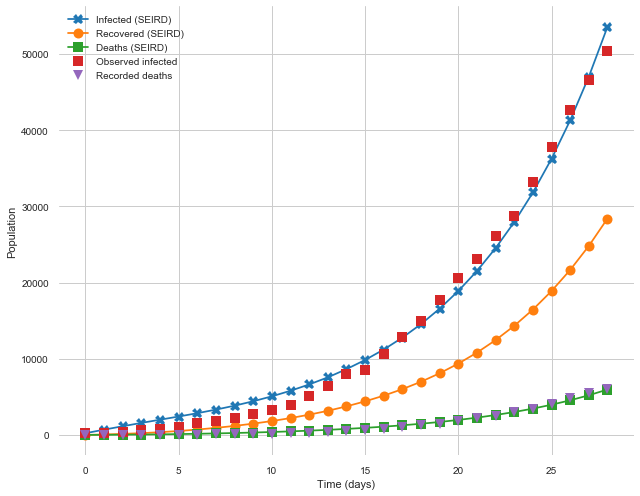

In [31]:
plt.figure(figsize=(9,7))
if has_to_run_seird:
    plt.plot(t_computed_seird, I_seird * target_population, label='Infected (SEIRD)', marker='X', linestyle="-", markersize=10)
    plt.plot(t_computed_seird, R_seird * target_population, label='Recovered (SEIRD)', marker='o', linestyle="-", markersize=10)
    plt.plot(t_computed_seird, D_seird * target_population, label='Deaths (SEIRD)', marker='s', linestyle="-", markersize=10)

plt.plot(data_time, infected_individuals * target_population, label='Observed infected', marker='s', linestyle="", markersize=10)
plt.plot(data_time, dead_individuals * target_population, label='Recorded deaths', marker='v', linestyle="", markersize=10)
plt.legend()
plt.grid()
plt.xlabel('Time (days)')
plt.ylabel('Population')

plt.tight_layout()